In [1]:
import scanpy as sc
import anndata
import pandas as pd
# import STMGraph_pyG0 as STMGraph
# import SMGraph_pyG as STMGraph
import SM2ST as SMLED
# import SMLED
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.stats import pearsonr
os.environ['R_HOME'] = '/home/llx/software/minicbonda3/envs/pyg1/lib/R'

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# df_ms=pd.read_csv('/home/llx/project/jupyternotebook/1_pyg_backup/Data/MSD/mouse_brain_pen_dhb_50um_pixel_intensities.csv', skiprows=2,index_col=0)
df_ms=pd.read_csv('/home/llx/project/MSI_data/2025_2_21_mouse_brain/30um/ITO-PET-glass-30um_norm.csv',index_col=0)
df_ms

,x163_y1,x164_y1,x165_y1,x166_y1,x167_y1,x168_y1,x169_y1,x170_y1,x171_y1,x172_y1,...,x71_y170,x63_y171,x64_y171,x65_y171,x66_y171,x67_y171,x68_y171,x69_y171,x70_y171,x71_y171
152.021359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
152.056053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,334.673097,...,0.000000,110.767004,182.607266,249.665533,244.559977,197.091889,213.577722,0.000000,0.00000,0.000000
154.024872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,151.295990,191.294577,0.000000,219.571437,133.958821,119.555462,0.000000,0.00000,169.058085
155.033100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,348.037274,...,497.200251,645.162779,732.514020,578.802570,808.645552,473.498011,556.023016,367.690765,486.14473,535.842891
156.040253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,138.091976,0.000000,0.000000,0.000000,0.000000,100.330463,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002.579091,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
1003.583304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
1006.496537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
1020.535948,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


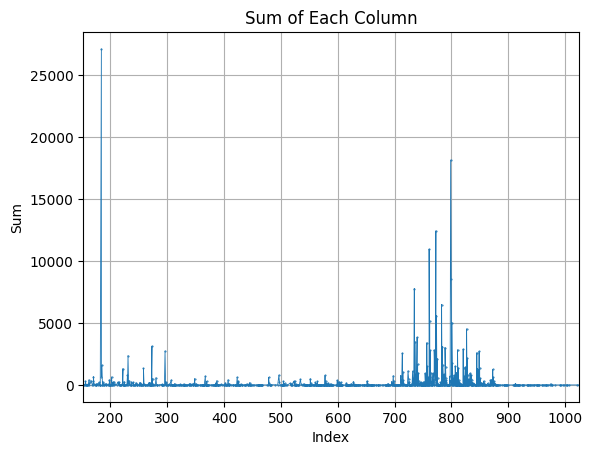

In [4]:
column_sums_i1 = df_ms.sum(axis = 1)/len(df_ms.columns)
column_sums_i1.index = column_sums_i1.index.astype(float)
# 绘制折线图
column_sums_i1.plot(kind='line', marker='.',linewidth=0.6, markersize=1)
plt.title('Sum of Each Column')
plt.xlabel('Index')
plt.ylabel('Sum')
plt.xticks(range(100, 1500, 100))  # 设置横轴刻度，每100个单位显示一个刻度
plt.xlim(column_sums_i1.index.min(), column_sums_i1.index.max())  # 设置横轴范围
plt.grid(True)
plt.show()

In [5]:
def create_anndata_or(dataframe=None,pixel_size=1,mask_radio=0.5):
    df_ms_new=dataframe.iloc[:,:].T#4
    # 检查每一行是否所有元素都是0
    rows_all_zero = (df_ms_new == 0).all(axis=1)

    # 使用布尔索引删除所有元素都是0的行
    df_ms_new = df_ms_new[~rows_all_zero]
    df_ms_new = df_ms_new.apply(lambda x: x - x.min(), axis=0)
    # 收集所有坐标到列表中
    rows = []
    cols = []
    for name in df_ms_new.index:
        x, y = name.split('_y')
        rows.append(int(x[1:]))
        cols.append(int(y))

    # 使用列表一次性创建DataFrame
    coordinates_df = pd.DataFrame({'array_row': rows, 'array_col': cols})
    coordinates_df.index = df_ms_new.index
    coordinates_physical_df = coordinates_df*pixel_size
    # 初始化 AnnData 对象
    index_df = pd.DataFrame(index=dataframe.index)
    adata = anndata.AnnData(X=df_ms_new.values, obs=coordinates_df, var=index_df)#4
    adata.obsm['spatial'] = coordinates_physical_df.values
    return adata

In [6]:
adata = create_anndata_or(dataframe=df_ms,pixel_size=30)

/home/llx/software/miniconda3/envs/pyg_ms/lib/python3.9/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


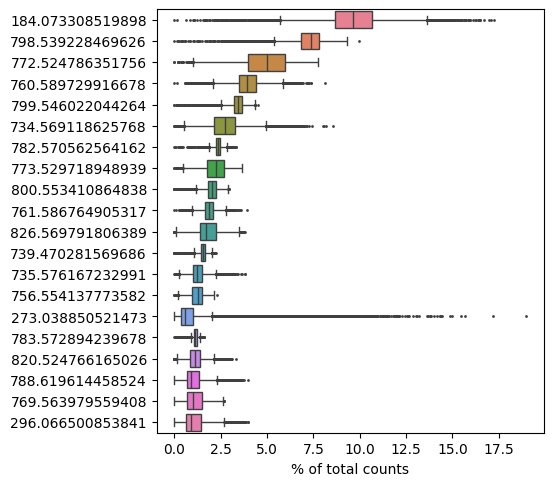

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20, )

<Axes: title={'center': '159.00465933054'}, xlabel='spatial1', ylabel='spatial2'>

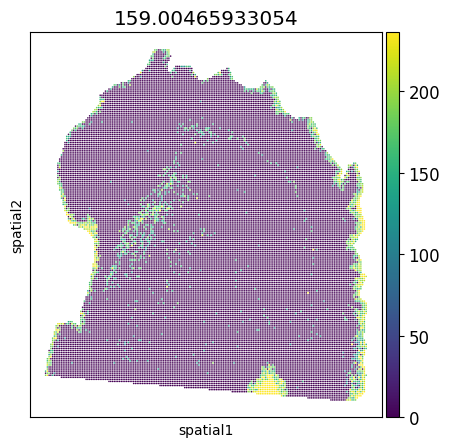

In [8]:
plot_gene = '159.00465933054'#C27H35N9O15P2Na
fig, ax = plt.subplots(figsize=(5, 5))  # 例如，figsize=(10, 8) 表示宽度为
plt.rcParams['font.size'] = 12  # 假设默认字体大小是10
sc.pl.embedding(adata, basis="spatial", color=plot_gene, show=False,vmax='p99', ax=ax)

In [9]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

<Axes: title={'center': '152.056052536344'}, xlabel='spatial1', ylabel='spatial2'>

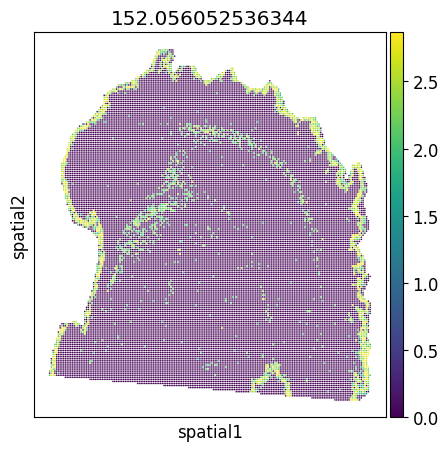

In [10]:
plot_gene = '152.056052536344' # C27H35N9O15P2Na
fig, ax = plt.subplots(figsize=(5, 5))  # 例如，figsize=(10, 8) 表示宽度为
plt.rcParams['font.size'] = 12  # 假设默认字体大小是10
sc.pl.embedding(adata, basis="spatial", color=plot_gene, show=False,vmax='p99', ax=ax)

In [12]:
#2,10000 0.3
adata_sample, adata_SMLED = SMLED.train_SMLED(adata=adata, mask_ratio=0.5, coord_sf=2.0, train_epoch=15000, save_reconstrction=True, experiment='recovery', WMMSE = 1.0)# 0.3 0.7

Size of Input:  (23626, 1273)
30.0 30.0
pixel_step: 60.0
          0     1
0      82.5   1.0
1      83.0   1.0
2      83.5   1.0
3      84.5   1.0
4      85.0   1.0
...     ...   ...
11808  32.5  86.0
11809  33.5  86.0
11810  34.0  86.0
11811  35.5  86.0
11812  36.0  86.0

[11813 rows x 2 columns]           0     1
0      82.0   1.0
1      82.5   1.0
2      83.0   1.0
3      83.5   1.0
4      84.0   1.0
...     ...   ...
23621  34.0  86.0
23622  34.5  86.0
23623  35.0  86.0
23624  35.5  86.0
23625  36.0  86.0

[23626 rows x 2 columns]


Epochs: 100%|██████████| 15000/15000 [4:51:37<00:00,  1.17s/it, loss_re: 0.12926, loss_lat: 0.31708, loss_GA: 0.00002, loss: 0.22440, loss_DA: 1.38629]  


<Axes: title={'center': '152.056052536344'}, xlabel='spatial1', ylabel='spatial2'>

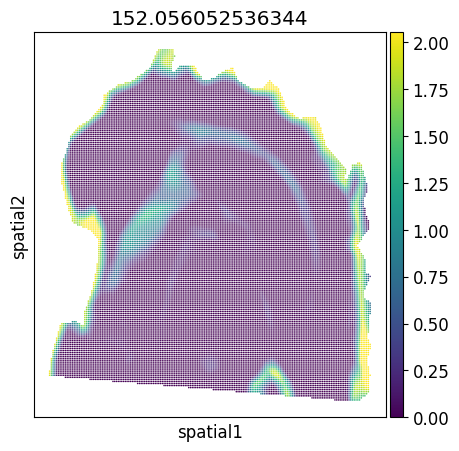

In [13]:
#new
plot_gene = '152.056052536344'#C27H35N9O15P2Na
fig, ax = plt.subplots(figsize=(5, 5))  # width = 15, height = 5
plt.rcParams['font.size'] = 12  #  default font size is 10
sc.pl.embedding(adata_SMLED, basis="spatial", color=plot_gene, show=False,vmax='p99', ax=ax)

<Axes: title={'center': '259.11315312222'}, xlabel='spatial1', ylabel='spatial2'>

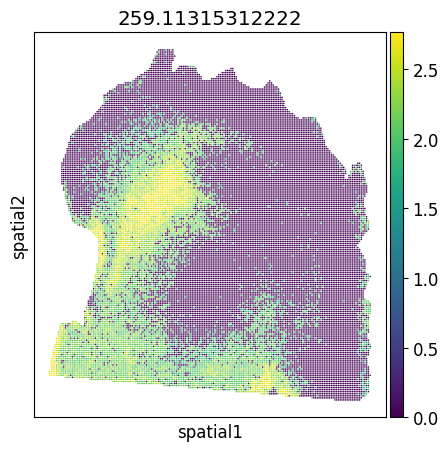

In [14]:
#new
plot_gene = '259.11315312222'#C27H35N9O15P2Na
fig, ax = plt.subplots(figsize=(5, 5))  # width = 15, height = 5
plt.rcParams['font.size'] = 12  #  default font size is 10
sc.pl.embedding(adata, basis="spatial", color=plot_gene, show=False,vmax='p99', ax=ax)

<Axes: title={'center': '259.11315312222'}, xlabel='spatial1', ylabel='spatial2'>

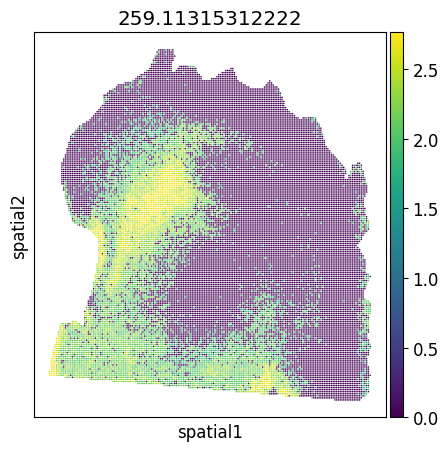

In [15]:
#new
plot_gene = '259.11315312222'#C27H35N9O15P2Na
fig, ax = plt.subplots(figsize=(5, 5))  # width = 15, height = 5
plt.rcParams['font.size'] = 12  #  default font size is 10
sc.pl.embedding(adata, basis="spatial", color=plot_gene, show=False,vmax='p99', ax=ax)

<Axes: title={'center': '259.11315312222'}, xlabel='spatial1', ylabel='spatial2'>

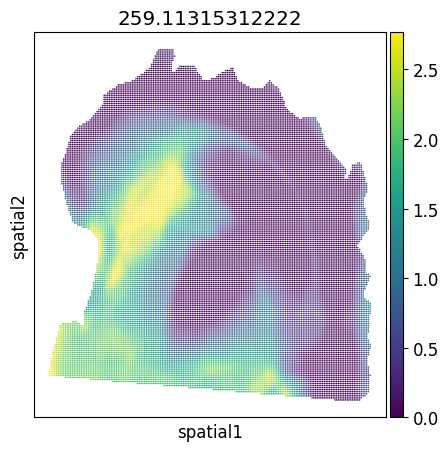

In [16]:
#new
plot_gene = '259.11315312222'#C27H35N9O15P2Na
fig, ax = plt.subplots(figsize=(5, 5))  # width = 15, height = 5
plt.rcParams['font.size'] = 12  #  default font size is 10
sc.pl.embedding(adata_SMLED, basis="spatial", color=plot_gene, show=False,vmax='p99', ax=ax)

<Axes: title={'center': '152.056052536344'}, xlabel='spatial1', ylabel='spatial2'>

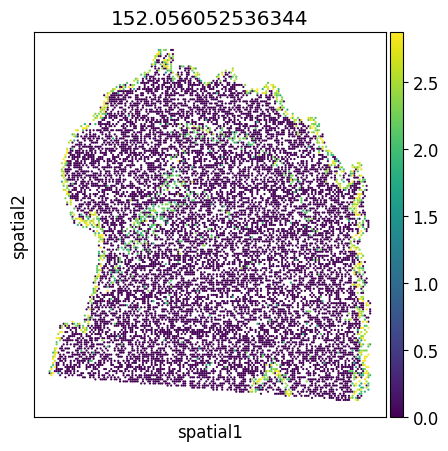

In [17]:
#new
plot_gene = '152.056052536344'#C27H35N9O15P2Na
fig, ax = plt.subplots(figsize=(5, 5))  # width = 15, height = 5
plt.rcParams['font.size'] = 12  #  default font size is 10
sc.pl.embedding(adata_sample, basis="spatial", color=plot_gene, show=False,vmax='p99', ax=ax)

<Axes: title={'center': '259.11315312222'}, xlabel='spatial1', ylabel='spatial2'>

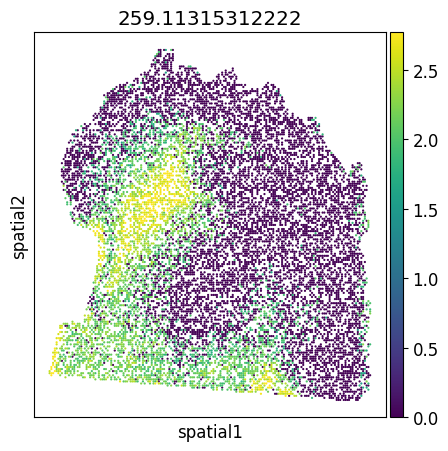

In [18]:
#new
plot_gene = '259.11315312222'#C27H35N9O15P2Na
fig, ax = plt.subplots(figsize=(5, 5))  # width = 15, height = 5
plt.rcParams['font.size'] = 12  #  default font size is 10
sc.pl.embedding(adata_sample, basis="spatial", color=plot_gene, show=False,vmax='p99', ax=ax)

<Axes: title={'center': '159.00465933054'}, xlabel='spatial1', ylabel='spatial2'>

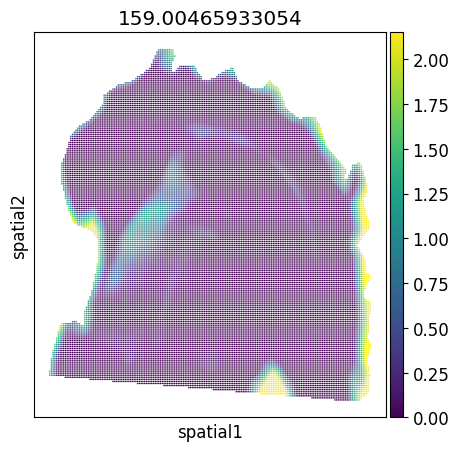

In [19]:
plot_gene = '159.00465933054'#C27H35N9O15P2Na
fig, ax = plt.subplots(figsize=(5, 5))  # 例如，figsize=(10, 8) 表示宽度为
plt.rcParams['font.size'] = 12  # 假设默认字体大小是10
sc.pl.embedding(adata_SMLED, basis="spatial", color=plot_gene, show=False,vmax='p99', ax=ax)

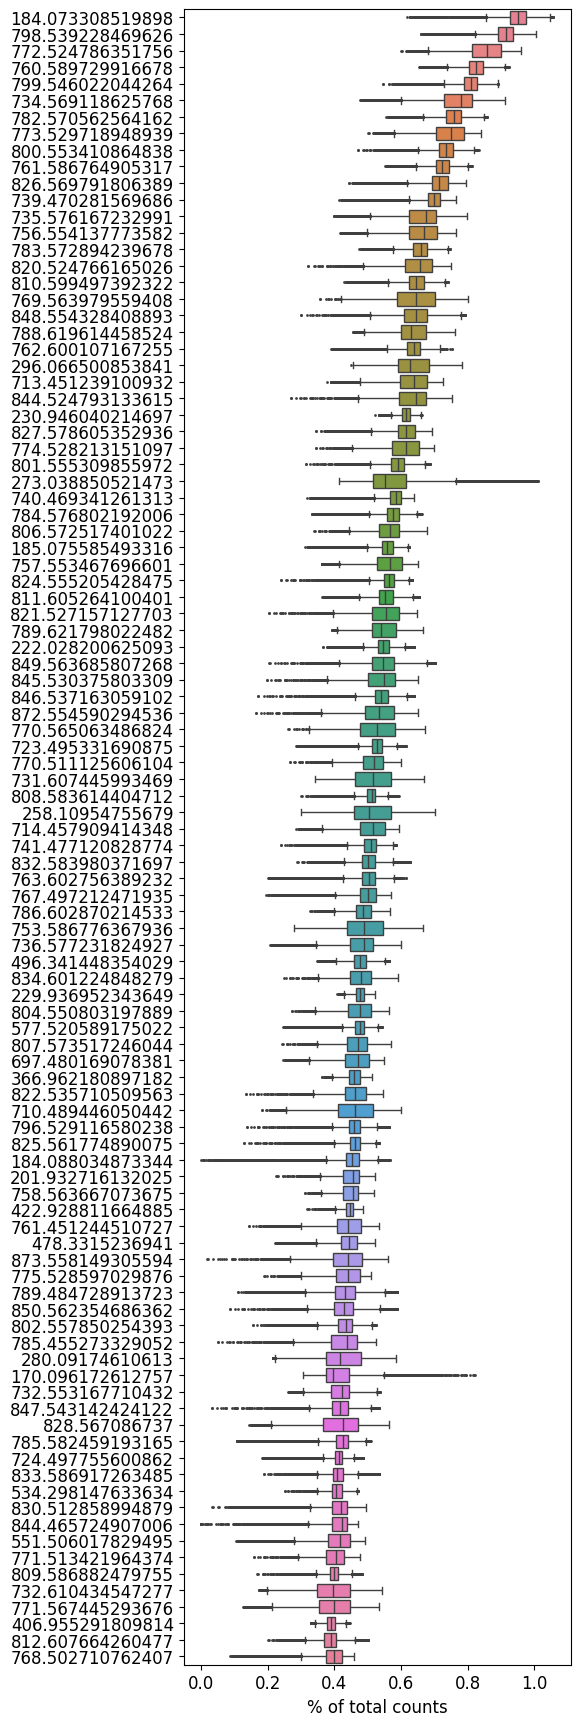

In [21]:
sc.pl.highest_expr_genes(adata_SMLED, n_top=100, )

In [22]:
adata_SMLED

AnnData object with n_obs × n_vars = 23626 × 1273
    obs: 'array_row', 'array_col'
    obsm: 'spatial'

In [24]:
adata_SMLED.write_h5ad('/home/llx/project/jupyternotebook/1_pyg_backup/SMLED_pyG_result/ITO-PET-glass-30um_SMLEDo.h5ad')
adata_sample.write_h5ad('/home/llx/project/jupyternotebook/1_pyg_backup/SMLED_pyG_result/ITO-PET-glass-30um_sampleo.h5ad')

In [14]:
adata_SMLED=sc.read_h5ad('/home/llx/project/jupyternotebook/1_pyg_backup/SMLED_pyG_result/ITO-PET-glass-30um_SMLEDo.h5ad')
adata_sample = sc.read_h5ad('/home/llx/project/jupyternotebook/1_pyg_backup/SMLED_pyG_result/ITO-PET-glass-30um_sampleo.h5ad')

In [19]:
adata_sample

AnnData object with n_obs × n_vars = 13770 × 1389
    obs: 'array_row', 'array_col'
    uns: 'log1p'
    obsm: 'spatial'

In [17]:
adata

AnnData object with n_obs × n_vars = 23626 × 1273
    obs: 'array_row', 'array_col'
    uns: 'log1p'
    obsm: 'spatial'

In [18]:
adata_SMLED

AnnData object with n_obs × n_vars = 23626 × 1273
    obs: 'array_row', 'array_col'
    obsm: 'spatial'

In [22]:
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import pandas as pd
# 假设 A 和 B 是我们要比较的两个矩阵
A = adata_SMLED[adata_sample.obs_names,:].X.A
B = adata[adata_sample.obs_names,:].X

# 计算每一行之间的皮尔逊相关系数和 p 值
r_values = []
p_values = []
for col1, col2 in zip(A, B):
    r_value, p_value = pearsonr(col1, col2)
    r_values.append(r_value)
    p_values.append(p_value)
# 计算皮尔森相关系数和p值
# r, p = pearsonr(A_flat, B_flat)

# print(f'Pearson Correlation Coefficient (r): {r}')
# print(f'P-value: {p}')

In [23]:
median = np.median(r_values)
median

0.9678474059789861

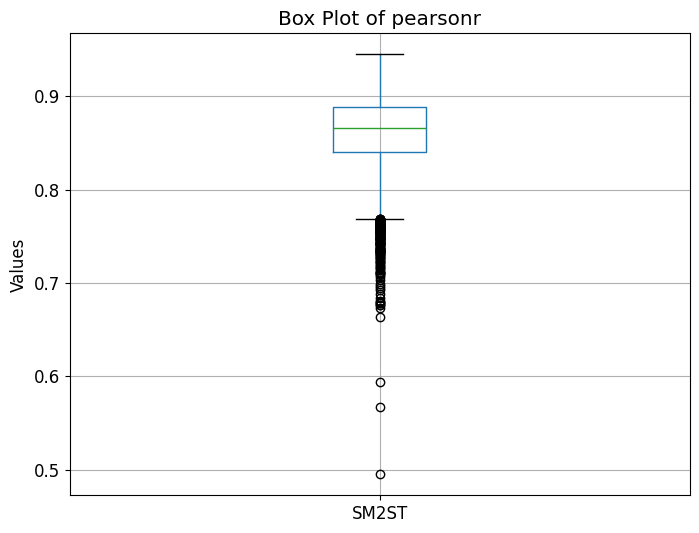

In [24]:
# 转换为DataFrame
df = pd.DataFrame(r_values, columns=['SM2ST'])
# 绘制箱线图
plt.figure(figsize=(8, 6))  # 可以指定图形的大小
df.boxplot()

# 添加标题和轴标签
plt.title('Box Plot of pearsonr')
plt.suptitle('')  # 去掉默认的副标题
plt.xlabel('')#Columns
plt.ylabel('Values')

# 显示图表
plt.show()